In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [6]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras


In [7]:
# get results of DDIM and naive
def _add_res(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    for ky, v in cur_paras.items():
        dict_res[ky].append(v)
        
# results of CQR and CF
def _add_ores(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    dict_res["rep"].append(_get_rep(ofil))
        

# get opt obs based on val set
def _get_opt_obs_given_repix(rep_ix, all_res_df, method_key="DDPM", cutoff=None):
    cols = ["method", "lr", "n_infeat", "n_T", "weight_decay", "upblk", "downblk", "rep"]
    kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)));
    if cutoff is not None:
        kpidx = np.bitwise_and(kpidx, all_res_df["ITE"]>cutoff)
    if kpidx.sum() == 0:
        kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)))
    
    best_val = all_res_df[kpidx].sort_values(by="Len").iloc[0]
    mask = np.ones(all_res_df.shape[0], dtype=bool)
    for col in cols:
        if col.startswith("method"):
            #v = best_val[col]
            v = best_val[col].split("_val")[0]
            mask = np.bitwise_and(mask, all_res_df[col].isin([v]))
            
        else: 
            v = best_val[col]
            mask = np.bitwise_and(mask, all_res_df[col] == v)
    return all_res_df[mask]

In [ ]:
setting_prefix ="my2setting"
setting_order = [f"my2setting{si} d={d}" for si in [5, 6, 7, 8]]
setting_iters = [f"my2setting{ix}" for ix in range(5, 9)]
d = 1000


#setting_prefix ="leisetting"
#setting_order = [f"setting{si} d={d}" for si in [1, 2, 3, 4]]
#setting_iters = [f"setting{ix}" for ix in range(1, 5)]


In [29]:
cutoff = 0.95
all_res_dfs = []
for setting in setting_iters:
    print(f"{setting} d={d}")
    res_dir = RES_ROOT/f"simu_{setting}_d{d}_n3000"
    all_fils = list(res_dir.glob("*n_T-*.pkl"));
    our_res = ddict(list)
    for fil in all_fils:
        cur_paras = fil_name2paras(fil.stem);
        res = load_pkl(fil, verbose=False);
        
        _add_res(res, key="DDIM", dict_res=our_res)
        _add_res(res, key="DDIM_val", dict_res=our_res)
        _add_res(res, key="naive", dict_res=our_res)
        _add_res(res, key="naive_val", dict_res=our_res)
        
        for model_ix in range(500, 6000, 500):
            _add_res(res, key=f"DDIM_ep{model_ix}", dict_res=our_res)
            _add_res(res, key=f"DDIM_ep{model_ix}_val", dict_res=our_res)
            _add_res(res, key=f"naive_ep{model_ix}", dict_res=our_res)
            _add_res(res, key=f"naive_ep{model_ix}_val",dict_res=our_res)
            
    
    _get_rep = lambda p: int(p.stem.split("_")[1])
    ofils = list(res_dir.glob("*other*.pkl"));
    other_res = ddict(list);
    for ofil in ofils:
        res = load_pkl(ofil, verbose=False);
        _add_ores(res, key="CQR", dict_res=other_res)
        _add_ores(res, key="CF", dict_res=other_res)
        
        
        
    other_res_df = pd.DataFrame(other_res);
    our_res_df = pd.DataFrame(our_res);
    
    our_res_df1 = our_res_df#[our_res_df['method'].map(lambda x: "ep1000" not in x)];
    best_res = []
    for cur_rep in list(set(our_res_df1["rep"])):
        best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "naive", cutoff))
        best_res.append(_get_opt_obs_given_repix(cur_rep, our_res_df1, "DDIM", cutoff))
        
    best_res = pd.concat(best_res);
    best_res1 = best_res.copy();
    best_res["method"] = best_res["method"].map(lambda x: x.split("_")[0])
    best_res = best_res[["Len", "ITE", "method", "rep"]];
    
    # put the results together
    all_res_df = pd.concat([best_res, other_res_df])
    all_res_df["setting"] = f"{setting} d={d}"
    all_res_dfs.append(all_res_df)

my2setting5 d=1000
my2setting6 d=1000
my2setting7 d=1000
my2setting8 d=1000


In [30]:
all_res_df_com = pd.concat(all_res_dfs);
all_res_df_com.reset_index(drop=True);


method_order=["DDIM", "CQR", "naive", "CF"]
setting_name = ["Homo. + Ind.", "Homo. + Corr.", "Hetero. + Ind.", "Hetero. + Corr."];

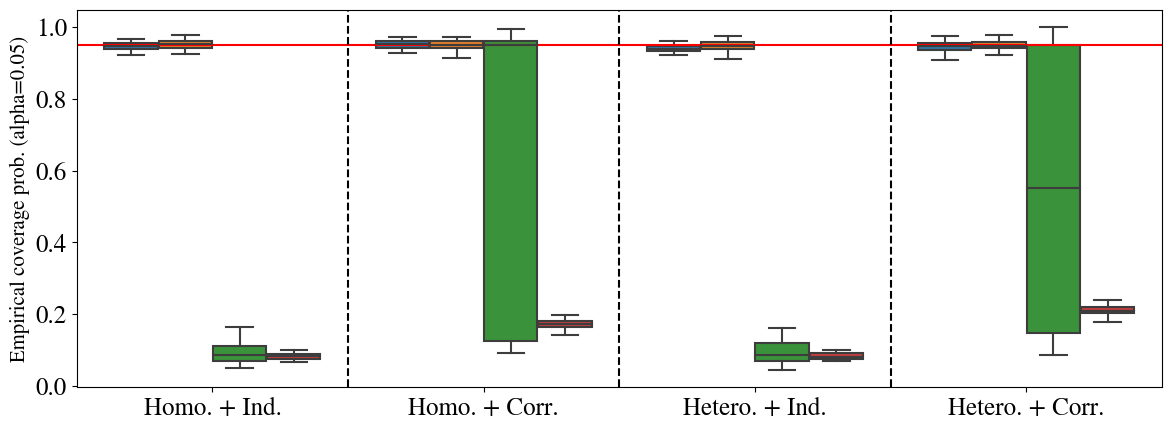

In [31]:
plt.figure(figsize=[14, 5])
sns.boxplot(data=all_res_df_com, y="ITE", hue="method", x="setting", showfliers=False,
            order=setting_order,
            hue_order=method_order, orient='v')
plt.axhline(y=0.95, color="red");
for s_ix in range(3):
    plt.axvline(x=s_ix+0.5, color="black", ls="--")
plt.xlabel('')
plt.ylabel("Empirical coverage prob. (alpha=0.05)", fontsize=15)
#plt.ylabel("Median length of interval estimates", fontsize=15)
plt.legend([],[], frameon=False)
plt.xticks(np.arange(4), setting_name);
plt.savefig(FIG_ROOT/f"{setting_prefix}_d{d}_prob.jpg")

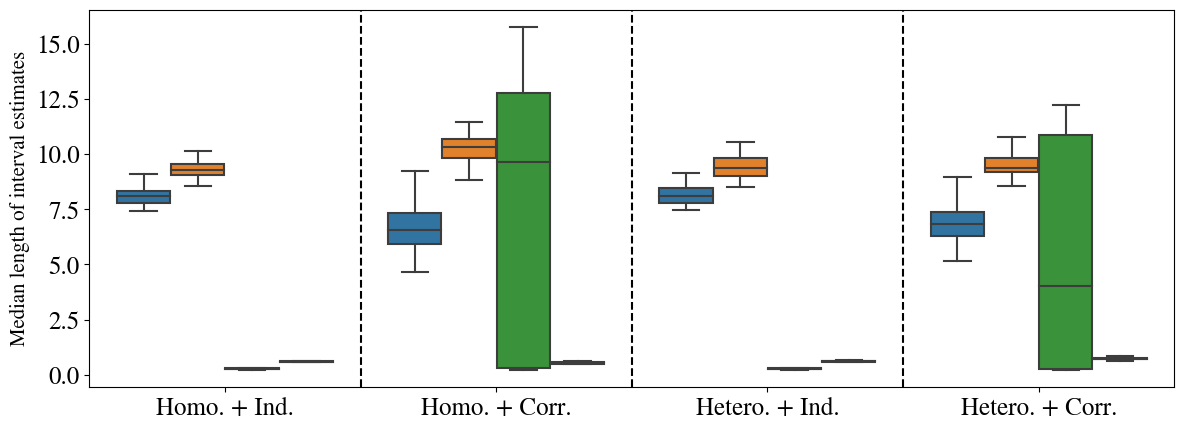

In [32]:
plt.figure(figsize=[14, 5])
sns.boxplot(data=all_res_df_com, y="Len", hue="method", x="setting", showfliers=False,
            order=setting_order,
            hue_order=method_order, orient='v')
for s_ix in range(3):
    plt.axvline(x=s_ix+0.5, color="black", ls="--")
plt.xlabel('')
plt.ylabel("Median length of interval estimates", fontsize=15)
plt.legend([],[], frameon=False)
plt.xticks(np.arange(4), setting_name);
plt.savefig(FIG_ROOT/f"{setting_prefix}_d{d}_len.jpg")

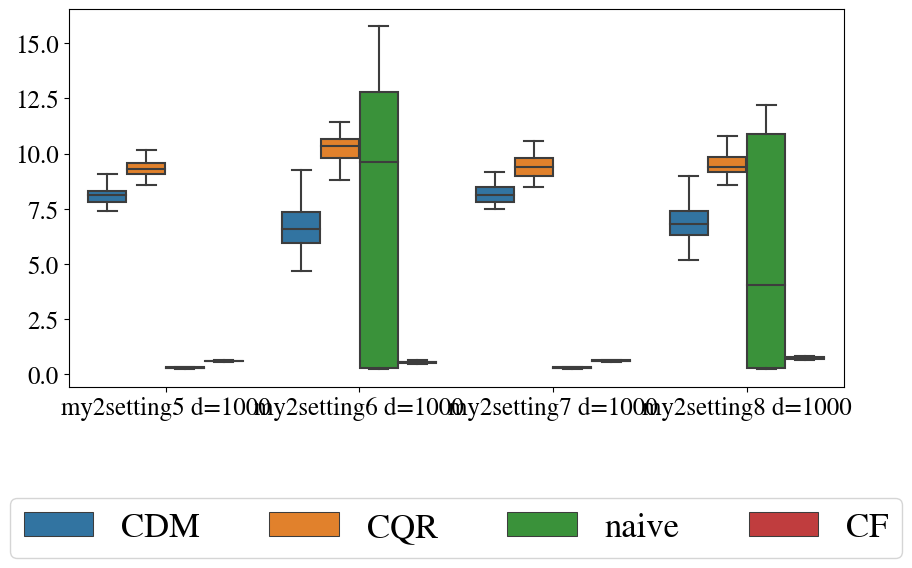

In [58]:
my_method = "CDM"
all_res_df_com1 = all_res_df_com.copy()
all_res_df_com1["method"] = all_res_df_com1["method"].map(lambda x: my_method if x == "DDIM" else x)

method_order1 =[my_method, "CQR", "naive", "CF"]
# only need the legend
sns.boxplot(data=all_res_df_com1, y="Len", hue="method", x="setting", showfliers=False,
            order=setting_order,
            hue_order=method_order1, orient='v')
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=4)
plt.savefig(FIG_ROOT/f"lenged.jpg")